<a href="https://colab.research.google.com/github/alirezaght/bitcoin-price-prediction/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download historical data

I'm downloading btc price from https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv

and eth price from https://www.cryptodatadownload.com/cdd/Bitstamp_ETHUSD_d.csv

and gold price from https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical

and oil price from https://www.nasdaq.com/market-activity/commodities/cl:nmx/historical

In [2]:
!gdown 11IppFUtMJ6CSs4AAc_mAz8DpIrESY03H
!gdown 1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
!gdown 1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv
!gdown 1CucFfrWKJJGngd8PaZXv1ygnFpNnyeJl

Downloading...
From: https://drive.google.com/uc?id=11IppFUtMJ6CSs4AAc_mAz8DpIrESY03H
To: /content/gold-price.csv
100% 116k/116k [00:00<00:00, 28.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
To: /content/btc-price.csv
100% 285k/285k [00:00<00:00, 50.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv
To: /content/eth-price.csv
100% 186k/186k [00:00<00:00, 28.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CucFfrWKJJGngd8PaZXv1ygnFpNnyeJl
To: /content/oil-price.csv
100% 109k/109k [00:00<00:00, 25.2MB/s]


# Preprocess *data*

In [17]:
from tensorflow.python.ops.ragged.row_partition import np
from functools import reduce 
import pandas as pd
from datetime import datetime
import math

gold_csv = pd.read_csv('gold-price.csv', keep_default_na=False)
btc_csv = pd.read_csv('btc-price.csv', keep_default_na=False)
eth_csv = pd.read_csv('eth-price.csv', keep_default_na=False)
oil_csv = pd.read_csv('oil-price.csv', keep_default_na=False)



feed_days = 90
indicators = 5
evaluate_days = 30

oils = {}
# oils_vols = {}

for i in range(0, len(oil_csv)):  
  # if oil_csv.iloc[i, 2] == "N/A":
    # continue
  oil_time = datetime.strptime(oil_csv.iloc[i, 0], "%m/%d/%Y").timestamp()
  oils[oil_time] = float(oil_csv.iloc[i, 3])  
  # oils_vols[oil_time] = float(oil_csv.iloc[i, 2])

original = []

index = 1
for i in range(0, len(gold_csv)):  
  if i >= len(btc_csv) or i >= len(eth_csv):
    break
  gold_time = datetime.strptime(gold_csv.iloc[i, 0], "%m/%d/%Y").timestamp()
  if gold_time not in oils:
    continue
  
  oil_price = oils[gold_time]
  # oil_vol = oils_vols[gold_time]
  gold_price = float(gold_csv.iloc[i, 3]) # open price  
  # if gold_csv.iloc[i, 2] == "N/A":
    # continue
  # gold_vol = float(gold_csv.iloc[i, 2])   
  while True: 
    if index >= len(btc_csv) or index >= len(eth_csv):
      break   
    btc_time = float(btc_csv.iloc[index].name[0])
    if btc_time < gold_time:      
      break   
    btc_price = float(btc_csv.iloc[index].name[3]) # open price        
    btc_vol = float(btc_csv.iloc[index][0]) 
    eth_price = float(eth_csv.iloc[index].name[3]) # open price    
    # eth_vol = float(eth_csv.iloc[index][0]) 
    index += 1
    original.append([btc_price, btc_vol, gold_price, eth_price, oil_price])
original = np.array(original[::-1])

print("Length of btc data: ", len(btc_csv))
print("Length of eth data: ", len(eth_csv))
print("Length of oil data: ", len(oil_csv))
print("Length of gold data: ", len(gold_csv))
print("Length of data: ", len(original))


Length of btc data:  2926
Length of eth data:  1849
Length of oil data:  2547
Length of gold data:  2547
Length of data:  1848


# Scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(original)

x_train = []
y_train = []
for i in range(feed_days, len(data)):
  x_train.append(np.reshape(data[i - feed_days: i], (1, feed_days * indicators)))
  y_train.append(data[i][0])


x_train = np.reshape(x_train, (len(x_train), feed_days, indicators))
y_train = np.reshape(y_train, (len(y_train)))


# Build Model and Train

In [19]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from keras import backend as K

In [20]:
print(tf.__version__)

2.9.2


In [68]:
batch_size = 32
alpha = 1000
direction = None
def custom_loss(y, y_pred):
  global direction
  t = y * y_pred
  indices = tf.where(t < 0)[:, 0] 
  
  if direction is None:
    direction = tf.Variable(tf.ones_like(y_pred), dtype='float32')     
  updates = K.cast(tf.ones_like(indices), dtype='float32')
  updates = updates * alpha
  if indices.shape[0] is not None:    
    direction.assign(tf.tensor_scatter_nd_update(direction, indices, updates))
  else:
    direction.assign(tf.ones_like(y))
  

  custom_loss = K.mean(tf.multiply(K.square(y - y_pred), direction), axis=-1)
  return custom_loss

In [69]:
model = keras.Sequential()

model.add(layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(32))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 32, activation="relu"))

model.add(layers.Dense(units = 1))
model.compile(optimizer="adam", loss=custom_loss)
model.fit(x_train[0: len(x_train) - evaluate_days], y_train[0: len(y_train) - evaluate_days], epochs=30, batch_size=batch_size)

Epoch 1/30
 8/54 [===>..........................] - ETA: 20s - loss: 0.0850

KeyboardInterrupt: ignored

# Predict

1/1 [==============================] - 0s 45ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 46ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 43ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 46ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 49ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 47ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))


1/1 [==============================] - 0s 43ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 43ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 46ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

1/1 [==============================] - 0s 48ms/step


<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
<ipython-input-16-f0053bfaafef>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

End Prediction: 0.18237658593558628 20760.531944360733 24546.766882579923
Eval Prediction: -0.19792124139950226 20493.0 16437.0
Min: 0.0 20760.531944360733
Eval Min: -0.23110330356707168 15757.0
Max: 0.18237658593558628 24546.766882579923
Eval Max: 0.03933050309861904 21299.0


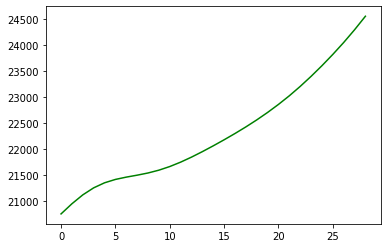

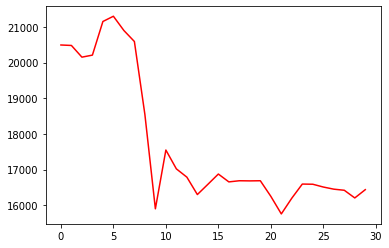

In [16]:
import matplotlib.pyplot as plt

predict_days = 30

x = np.array([])
x = np.append(x, original[len(original) - feed_days - evaluate_days: len(original) - evaluate_days])
x = np.reshape(x, (feed_days, indicators))
x = scaler.transform(x)
x = np.reshape(x, (1, feed_days, indicators))
res_array = np.array([])
y_array = np.array([])
for i in range(1, predict_days):
  res = scaler.inverse_transform(np.reshape(np.array([model.predict(x)[0], 0, 0, 0, 0]), (1, indicators)))
  y_array = np.append(y_array, res[0][0])
  res_array = np.append(res_array, res[0][0])
  res_array = np.append(res_array, original[len(original) - 1 - evaluate_days][1:])
  res_array = np.reshape(res_array, (i, indicators))  
  x = np.append(original[len(original) - feed_days - evaluate_days + i: len(original) - evaluate_days], res_array, axis = 0)    
  x = scaler.transform(x)
  x = np.reshape(x, (1, feed_days, indicators))

e_array = np.array([])


if evaluate_days > 0:
  for i in range(0, evaluate_days):
    e_array = np.append(e_array, original[len(original) - evaluate_days + i][0])
  plt.figure(1).gca().plot(y_array, color="green")
  plt.figure(2).gca().plot(e_array, color="red")
else:
  plt.plot(y_array, color='green')
print("End Prediction:", (y_array[len(y_array) - 1] - y_array[0])/y_array[0], y_array[0], y_array[len(y_array) - 1])
if evaluate_days > 0:  
  print("Eval Prediction:", (e_array[len(e_array) - 1] - e_array[0])/e_array[0], e_array[0], e_array[len(e_array) - 1])
print("Min:", (min(y_array) - y_array[0])/y_array[0], min(y_array))
if evaluate_days > 0:
  print("Eval Min:", (min(e_array) - e_array[0])/e_array[0], min(e_array))  
print("Max:", (max(y_array) - y_array[0])/y_array[0], max(y_array))
if evaluate_days > 0:
  print("Eval Max:", (max(e_array) - e_array[0])/e_array[0], max(e_array))  